# Libraries

In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Import

In [ ]:
df = pd.read_csv(r"Datasets/WineQualityDuplicate.csv")

# Feature Seperation

In [ ]:
X = df.drop(columns=['quality', 'type'])
y = df['quality']

# Categorization

In [ ]:
y = y.astype('category')
class_mapping = {cat: i for i, cat in enumerate(y.cat.categories)}

# Train Test Split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Scaling

In [ ]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Feature and Variable Conversion

In [ ]:
X_train_t = torch.tensor(X_train_scaled, dtype=torch.float32)
X_test_t = torch.tensor(X_test_scaled, dtype=torch.float32)
y_train_t = torch.tensor(y_train.values, dtype=torch.long)
y_test_t = torch.tensor(y_test.values, dtype=torch.long)

# Data Retrieval, Storage, and Instantiation

In [ ]:
class WineDataset(Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

train_dataset = WineDataset(X_train_t, y_train_t)
test_dataset = WineDataset(X_test_t, y_test_t)

# Data Loading

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Deep Neural Network Class

In [ ]:
class DNNClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dims, num_classes):
        super(DNNClassifier, self).__init__()
        layers = []
        
        prev_dim = input_dim
        for h_dim in hidden_dims:
            layers.append(nn.Linear(prev_dim, h_dim))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(0.2))
            prev_dim = h_dim
        
        layers.append(nn.Linear(prev_dim, 9))
        
        self.network = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.network(x)

# Model and Parameter Creation

In [ ]:
input_dim = X_train_t.shape[1]
num_classes = len(class_mapping)
hidden_dims = [128, 64, 32]

model = DNNClassifier(input_dim, hidden_dims, num_classes)

# Loss Function, Optimizer, and Epochs

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
epochs = 500

# Model Training

In [ ]:
model.train()
for epoch in range(epochs):
    running_loss = 0.0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
    
    epoch_loss = running_loss / len(train_loader.dataset)
    if (epoch+1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{epochs}] Loss: {epoch_loss:.4f}")

Epoch [10/500] Loss: 1.0045
Epoch [20/500] Loss: 0.9560
Epoch [30/500] Loss: 0.9094
Epoch [40/500] Loss: 0.8807
Epoch [50/500] Loss: 0.8469
Epoch [60/500] Loss: 0.8268
Epoch [70/500] Loss: 0.7998
Epoch [80/500] Loss: 0.7697
Epoch [90/500] Loss: 0.7448
Epoch [100/500] Loss: 0.7306
Epoch [110/500] Loss: 0.7128
Epoch [120/500] Loss: 0.6764
Epoch [130/500] Loss: 0.6691
Epoch [140/500] Loss: 0.6324
Epoch [150/500] Loss: 0.6377
Epoch [160/500] Loss: 0.6127
Epoch [170/500] Loss: 0.6226
Epoch [180/500] Loss: 0.5959
Epoch [190/500] Loss: 0.5911
Epoch [200/500] Loss: 0.5728
Epoch [210/500] Loss: 0.5337
Epoch [220/500] Loss: 0.5488
Epoch [230/500] Loss: 0.5400
Epoch [240/500] Loss: 0.5244
Epoch [250/500] Loss: 0.5257
Epoch [260/500] Loss: 0.5159
Epoch [270/500] Loss: 0.5172
Epoch [280/500] Loss: 0.5088
Epoch [290/500] Loss: 0.4931
Epoch [300/500] Loss: 0.4820
Epoch [310/500] Loss: 0.4841
Epoch [320/500] Loss: 0.4766
Epoch [330/500] Loss: 0.4829
Epoch [340/500] Loss: 0.4543
Epoch [350/500] Loss: 0

# Model Batch Evaluation

In [ ]:
model.eval()
y_pred_list = []
y_true_list = []

with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        y_pred_list.extend(preds.numpy())
        y_true_list.extend(labels.numpy())

# Accuracy

In [ ]:
accuracy = accuracy_score(y_true_list, y_pred_list)
report = classification_report(y_true_list, y_pred_list)

In [ ]:
print(f"Test Accuracy: {accuracy:.2f}")
print("Classification Report:")
print(report)

Test Accuracy: 0.64
Classification Report:
              precision    recall  f1-score   support

           4       0.17      0.07      0.10        15
           5       0.72      0.71      0.71       177
           6       0.66      0.66      0.66       247
           7       0.49      0.61      0.54        87
           8       0.17      0.07      0.10        14

    accuracy                           0.64       540
   macro avg       0.44      0.42      0.42       540
weighted avg       0.63      0.64      0.63       540



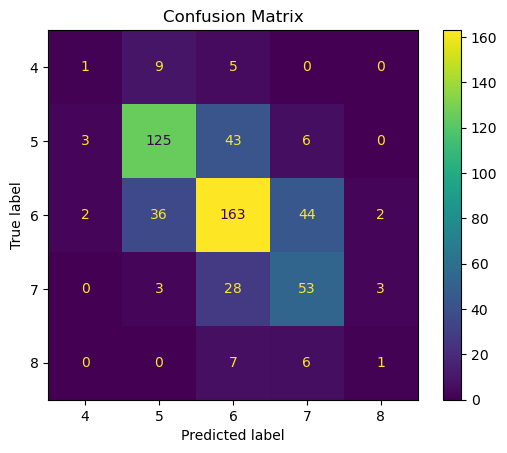

In [ ]:
cm = confusion_matrix(y_true_list, y_pred_list)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=y.cat.categories)
disp.plot(cmap="viridis")
plt.title("Confusion Matrix")
plt.show()